In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*4).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=int(periods/2)).mean()
    #data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
func = breakout
periods = [50]
start_date = '20190101'

In [11]:
s= '20180501'
params = {
    #'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s, periods=periods),
    #'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=periods),
    #'carver': calibrate_multiple(sym, carver, start_date=s, periods=periods, adjustment=40),
    #'roc': calibrate_multiple(sym, roc, start_date=s, periods=periods),
    #'roca': calibrate_multiple(sym, roca, start_date=s, periods=periods),
}
data = simulate(params[func.__name__], sym, func,periods=periods, start_date=start_date)

In [12]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.832377735584561, 7.35153269741172)

In [13]:
data

,open,close,break_50,forecast
date,,,,
2019-01-04 15:18:00,6264.25,6251.75,-3.419752,-3.419752
2019-01-04 15:31:00,6251.75,6250.00,-3.017428,-3.017428
2019-01-04 15:35:00,6249.75,6250.25,-2.662437,-2.662437
2019-01-04 15:39:00,6249.75,6271.50,-2.349209,-2.349209
2019-01-04 15:43:00,6271.50,6283.25,5.216232,5.216232
...,...,...,...,...
2019-12-31 21:37:00,8736.25,8740.00,-0.148658,-0.148658
2019-12-31 21:53:00,8740.00,8739.50,-0.131169,-0.131169
2019-12-31 21:59:00,8739.50,8748.00,-0.115737,-0.115737


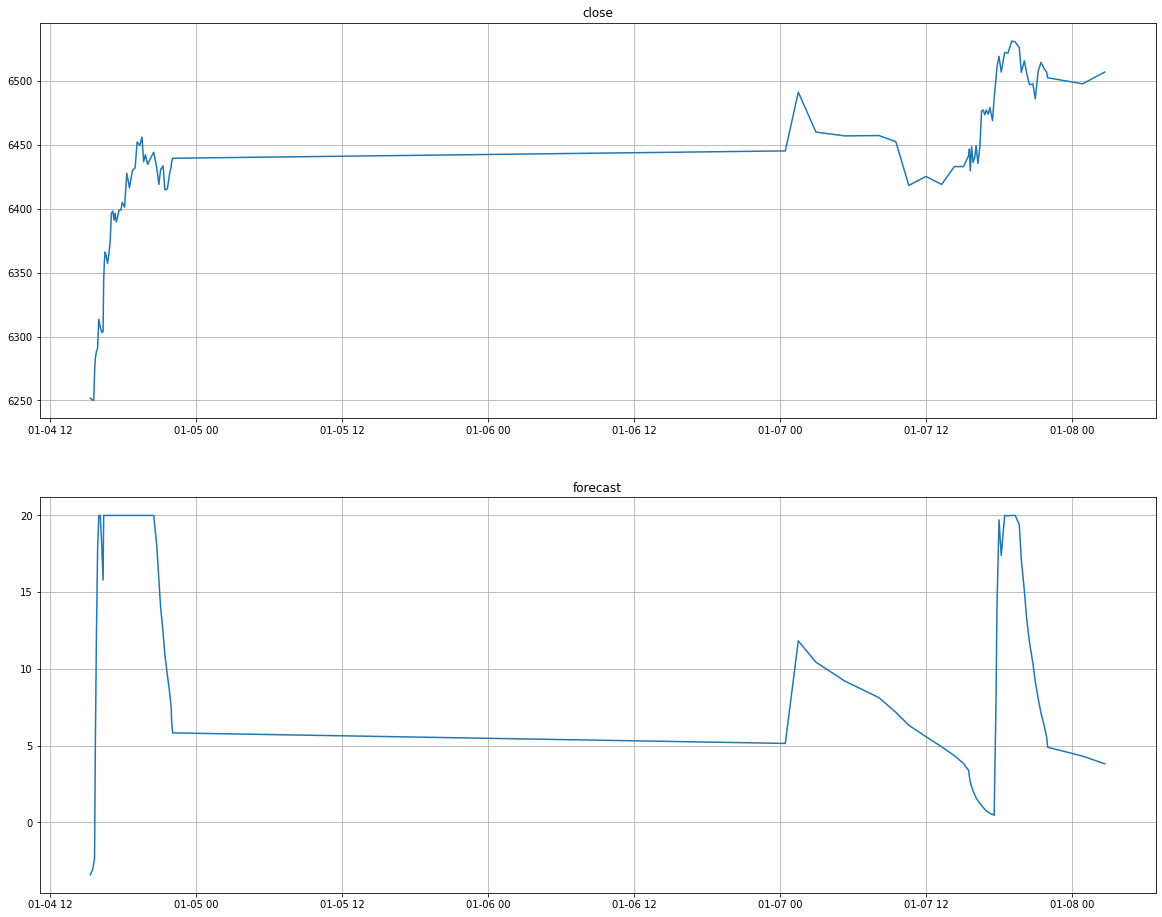

In [14]:
plot(data[['close', 'forecast']].iloc[:100])

In [15]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0094143,0.0710107,0.0506503,0.0355759,0.0260441,0.0661529,0.119948,0.121611,0.0834301
Cumulative returns,0.00956445,0.0721776,0.0514746,0.0361507,0.0264629,0.0672375,0.121964,0.123656,0.084809
Annual volatility,0.153255,0.126625,0.114752,0.108777,0.10526,0.0952995,0.0755609,0.0630638,0.0593298
Sharpe ratio,0.137552,0.604887,0.487705,0.37544,0.296575,0.719595,1.53712,1.85157,1.38029
Calmar ratio,0.0531773,0.611897,0.607929,0.438543,0.316275,1.20783,1.91749,2.52926,2.14545
Stability,0.000694461,0.0905398,0.0212323,0.0248836,0.0244838,0.457614,0.670598,0.783285,0.729781
Max drawdown,-0.177036,-0.11605,-0.0833162,-0.081123,-0.0823464,-0.0547701,-0.0625548,-0.0480816,-0.038887
Omega ratio,1.02376,1.11109,1.0895,1.06756,1.05403,1.14219,1.38059,1.47446,1.34234
Sortino ratio,0.19453,0.90649,0.738078,0.584558,0.461849,1.15564,2.5455,3.37339,2.51958
Skew,-0.148346,0.0588342,0.208807,0.507556,0.51761,0.567317,0.410442,0.915902,1.23495


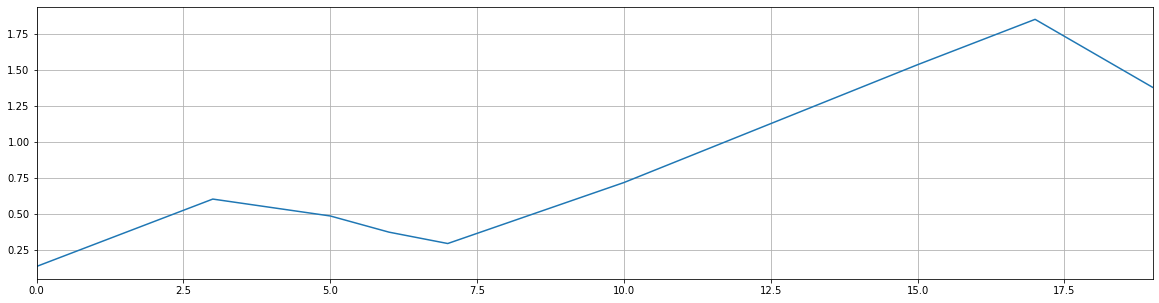

In [16]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [17]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.833899,0.760709,0.741418,0.711626,0.589198,0.550055,0.480265,0.475079
3,0.833899,1.000000,0.904488,0.863570,0.825963,0.712282,0.616754,0.556435,0.530884
5,0.760709,0.904488,1.000000,0.960387,0.917592,0.798355,0.673099,0.631633,0.603763
6,0.741418,0.863570,0.960387,1.000000,0.954432,0.840322,0.707021,0.660699,0.651162
7,0.711626,0.825963,0.917592,0.954432,1.000000,0.857981,0.743908,0.699478,0.684029
10,0.589198,0.712282,0.798355,0.840322,0.857981,1.000000,0.785438,0.740547,0.726492
15,0.550055,0.616754,0.673099,0.707021,0.743908,0.785438,1.000000,0.880746,0.788935
17,0.480265,0.556435,0.631633,0.660699,0.699478,0.740547,0.880746,1.000000,0.897374
19,0.475079,0.530884,0.603763,0.651162,0.684029,0.726492,0.788935,0.897374,1.000000


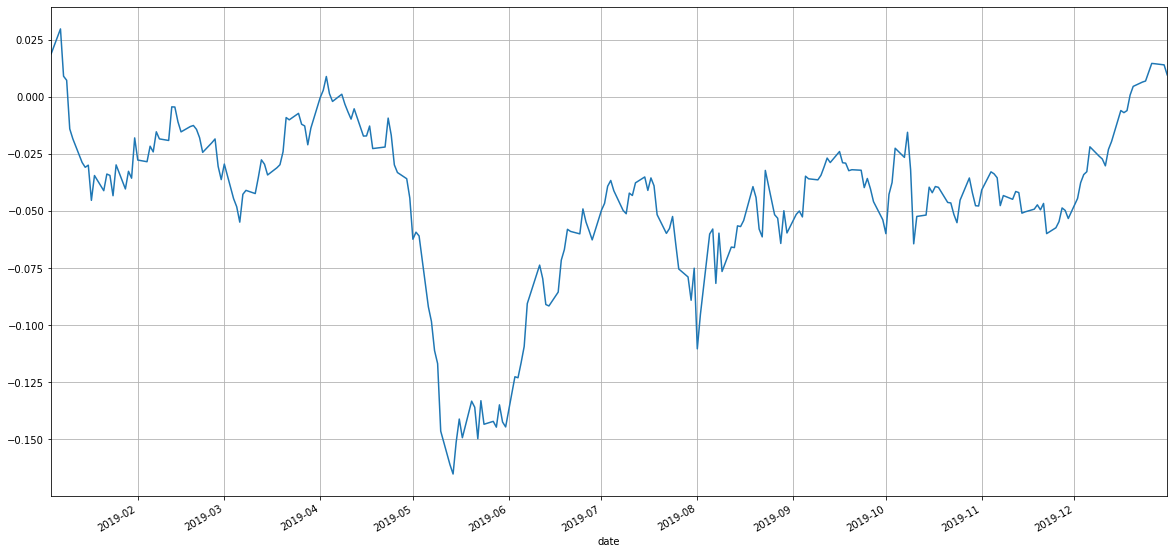

In [18]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

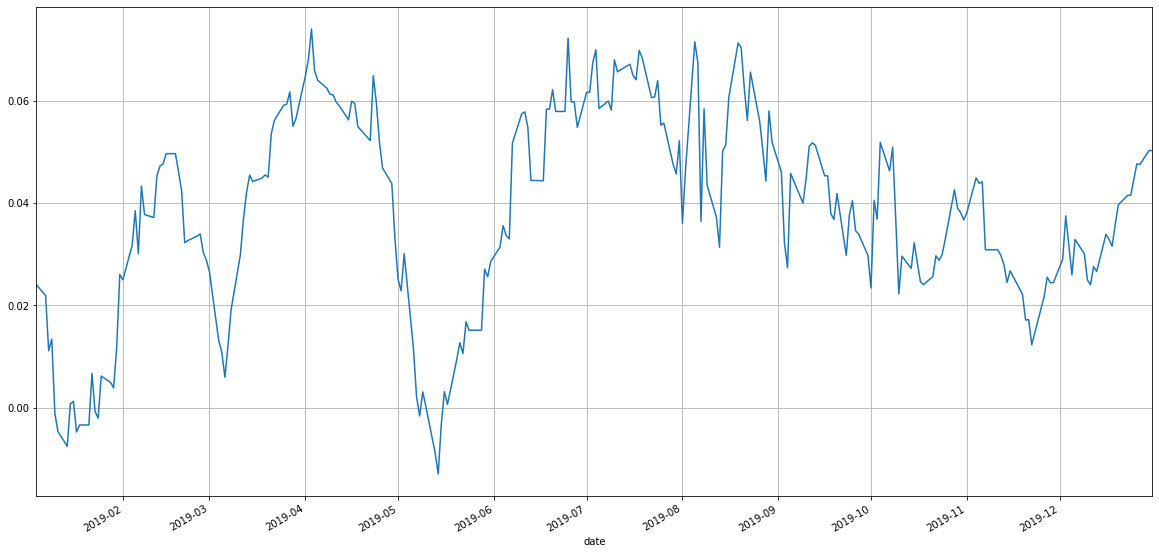

In [19]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

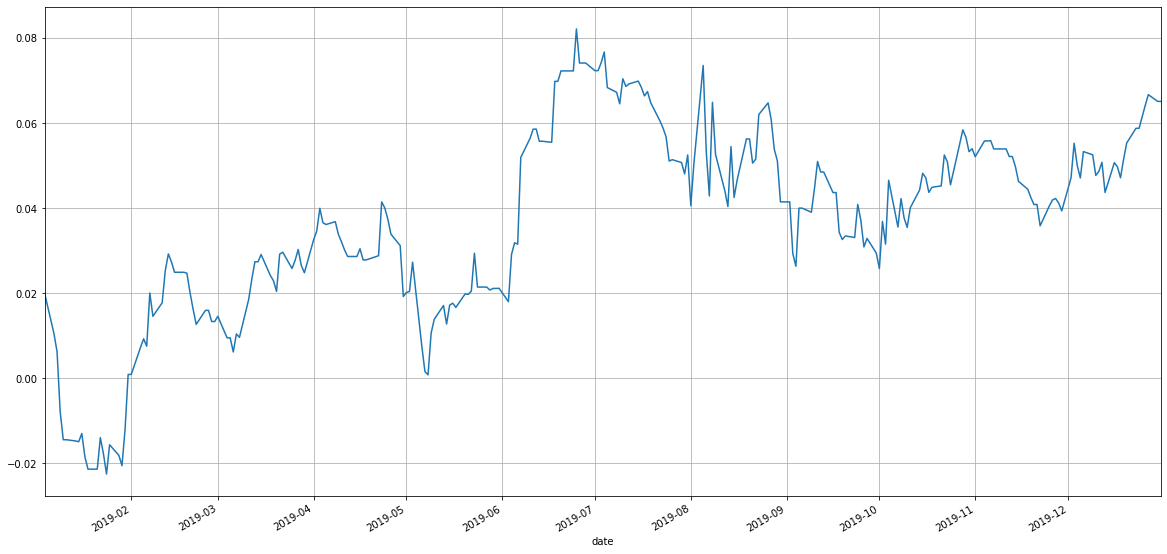

In [20]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

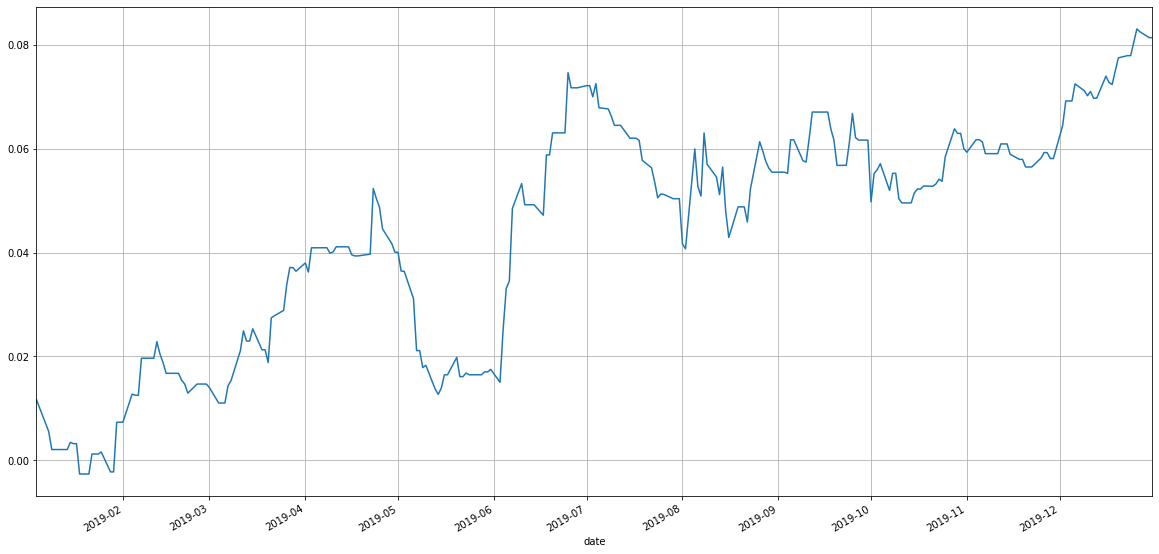

In [21]:
np.log(out.returns[19]+1).cumsum().plot(figsize=(20, 10), grid=True);